## IMPORTS

In [4]:
import tweepy
import json
import pandas
import time

## Default Constants (Developer Account Credentials)

In [5]:
API_KEY = 'C5q6LMdpgQ4kVW5XULQLWf2wb'
SECRET_API_KEY = 'YuimKb3FQZtgKxg9qsenMuRjRzJ182OhWNEOwplRpVvSuP6vEu'

ACCESS_TOKEN = '894046754278002690-p77KCeVgCaD8Q2li6bvU7AYybY6ZIYd'
SECRET_ACCESS_TOKEN = 'b1vbpt6Hft7WVzhlZhrvnAopt7rTxGpZFBESYKn6uwkbT'

## Establishing connection

In [6]:
auth = tweepy.OAuthHandler(API_KEY, SECRET_API_KEY)
auth.set_access_token(ACCESS_TOKEN, SECRET_ACCESS_TOKEN)

api = tweepy.API(auth , wait_on_rate_limit = True)

## Scraping Tweets based on keywords

In [ ]:
def tweetSearch(query, limit = 50, language = "en", remove = []):
    
    #Create a blank variable
    text = ""
    
    #Iterate through Twitter using Tweepy to find our query in our language, with our defined limit
    #For every tweet that has our query, add it to our text holder in lower case
    for tweet in tweepy.Cursor(api.search, q = query, lang = language).items(limit):
        text += tweet.text.lower()
    
    #Twitter has lots of links, we need to remove the common parts of links to clean our data
    #Firstly, create a list of terms that we want to remove. This contains https & co, alongside any words in our remove list
    removeWords = ["https","co"]
    removeWords += remove
    
    #For each word in our removeWords list, replace it with nothing in our main text - deleting it
    for word in removeWords:
        text = text.replace(word, "")
    
    #return our clean text
#     return text+"\n\n"
    print(text + "\n\n")

# tweetSearch("Sachin Tendulkar",100)
# listML = tweetSearch("Machine Learning")

In [63]:
def getTweets(query):
    tweetList = []
    for tweet in tweepy.Cursor(api.search , query , "en").items(20):
        tweetList.append(tweet.text)    
    return pandas.DataFrame(tweetList).rename(columns = {0 : "Tweets"})

## Getting user details using Twitter Handle

In [17]:
def getUserDetails(query):
    user = api.get_user(query)
#     print(user.name)
#     print(user.created_at)
#     print(user.followers_count)
#     print(user.friends_count)
#     print(user.location)
#     print(user.url) #Instagram
#     print(user.screen_name)
#     print(user.status.text)
    return user.name , user.created_at , user.followers_count , user.friends_count , user.location , user.url , user.screen_name , user.status.text

## User Timeline Using Handle

In [18]:
iterator = 0
for tweet in tweepy.Cursor(api.user_timeline , "realDonaldTrump" , "en").items(50):
    print(tweet.text)
    print(tweet.retweet_count)
    print(tweet.created_at)
    print("\n\n")
    iterator += 1
print(iterator)    

Today I am making good on my promise to defend our Farmers &amp; Ranchers from unjustified trade retaliation by foreign… https://t.co/cyjbVCxWhw
19620
2018-12-17 21:14:10



RT @WhiteHouse: On December 17, 1903, the first successful flight of Wilbur and Orville Wright's handcrafted biplane ushered in the age of…
7386
2018-12-17 17:02:36



Anytime you hear a Democrat saying that you can have good Border Security without a Wall, write them off as just an… https://t.co/k45700dfgN
27446
2018-12-17 16:05:30



It is incredible that with a very strong dollar and virtually no inflation, the outside world blowing up around us,… https://t.co/Lfqd1p8ijM
22457
2018-12-17 13:27:16



The DEDUCTIBLE which comes with ObamaCare is so high that it is practically not even useable! Hurts families badly.… https://t.co/0oAOKTi1bB
18771
2018-12-17 13:02:13



....The Russian Witch Hunt Hoax, started as the “insurance policy” long before I even got elected, is very bad for… https://t.co/ayatQRn6I5
27647
20

## Dataframe formation

In [19]:
userDetails = getUserDetails('realDonaldTrump')

<html> <h1 style = "color:red"> Tweet Analysis </h1></html>

## IMPORTS

In [7]:
%matplotlib inline
import tweepy
import json
import time
import re
import nltk
from nltk.corpus import stopwords
import string
from collections import Counter
import matplotlib.pyplot as pyplot
import pandas
from wordcloud import WordCloud , STOPWORDS
from textblob import TextBlob
from matplotlib import style

## TWEETS JSON DUMPS

In [9]:
class TweetListener(tweepy.streaming.StreamListener):
    # Time Limit calculated in seconds
    def __init__(self, time_limit = 60):
        self.start_time = time.time()
        self.limit = time_limit
        super(TweetListener , self).__init__()

    # Restricts scraping till limited second count
    def on_data(self, data):
        if (time.time() - self.start_time) < self.limit:
            try:
                with open('./tmp/data.json' , 'a') as file:
                    file.write(data)
                    return True
            except BaseException as be:
                print("Error on_data %s : " % str(be))
        else:
            return False

query = ['Donald Trump']        
twitterStream = tweepy.Stream(auth , TweetListener(90))
twitterStream.filter(track = query)

## CLEANING AND EXTRACTION (BROAD TOKENIZATION)

In [10]:
emoticons = r"""
    (?:
        [:=;] #Eyes
        [oO\-]? #Nose
        [D\)\]\(\]/\\OpP] #Mouth
    )"""

regex = [
    emoticons ,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # Mentions in twets
    r"(?:\#+[\w_]+[\w\'_\-]*[\w]_+)", # Hash tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[|*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # Links or URL's
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # Numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # Words with -and
    r'(?:[\w_]+)',
    r'(?:\S)'
]

regexTokens = re.compile(r'(' + '|'.join(regex) + ')' , re.VERBOSE | re.IGNORECASE)
emoticonsTokens = re.compile(r'^' + emoticons + '$' , re.VERBOSE | re.IGNORECASE)

def tokenize(s):
    return regexTokens.findall(s)

def preprocess(s , lowercase = False):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticonsTokens.search(token) else token.lower() for token in tokens]
    return tokens    

punctuation = list(string.punctuation)
stop = stopwords.words("English") + punctuation
filename = './tmp/data.json'

with open(filename , 'r' , newline = '\r\n') as file:
    count = Counter()
    for line in file:
        tweet =json.loads(line)
#         print(tweet["text"])
#         print(preprocess(tweet['text']))
        # List with all terms
        termsStop = [term for term in preprocess(tweet['text']) if term not in stop]
        
        # Count the terms only once (Freq)
        termsSingle = set(termsStop)
        
        # Count only the hashtags
        termsHash = [term for term in preprocess(tweet['text']) if term.startswith('#')]
        
        # Count terms only (excludes hashtags and mentions)
        termsOnly = [term for term in preprocess(tweet['text'].lower()) if term not in stop]
        
        # All the terms
        termsAll = [term for term in preprocess(tweet['text'])]
        
        newTerms = []
        for term in termsOnly:
            if len(term) > 3:
                newTerms.append(term)
                
        count.update(newTerms)
#     print(count.most_common(100))

## DATAFRAME FORMATION AND WORDCLOUD PLOT

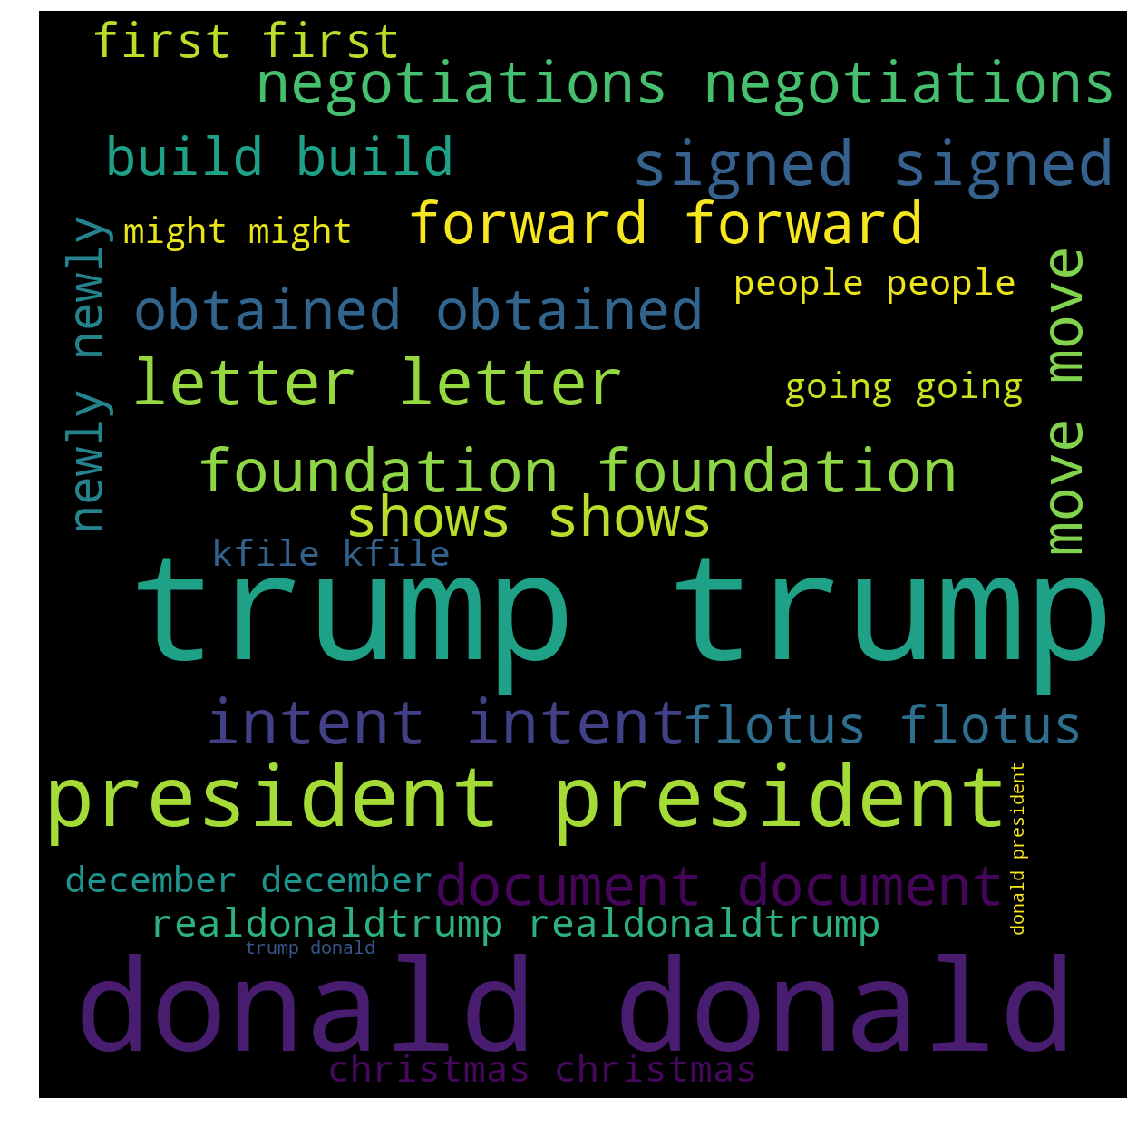

In [11]:
data = count.most_common(25)
dataframe = pandas.DataFrame(data)
dataframe.columns = ('Terms' , 'Frequency')
words = ' '
for index , row in dataframe.iterrows():
    words += (row.Terms + ' ') * row.Frequency

wordcloud = WordCloud(stopwords = STOPWORDS , background_color = "black" , width = 1200 , height = 1200).generate(words)
pyplot.figure(figsize = (26,20))
pyplot.imshow(wordcloud)
pyplot.axis("off")
pyplot.show()

In [12]:
class TweetSentimentListener(tweepy.streaming.StreamListener):
    def __init__(self, time_limit = 60):
        self.start_time = time.time()
        self.limit = time_limit
        super(TweetSentimentListener , self).__init__()
        
    def on_data(self , data):
        if (time.time() - self.start_time) < self.limit:
            try:
                megaData = json.loads(data)
                tweet = megaData['text']
                blob = TextBlob(tweet).sentiment
                if(blob.subjectivity * 100 >= 60):
                    file = open('./tmp/sentiments.txt' , 'a')
                    file.write(str(blob.polarity))
                    file.write('\n')
                    file.close()
                    return True
            except BaseException as be:
                print(str(be))
            return True 
        else:
            return False
        
#     def getSentiments():
#         megaData = json.loads(data)
#         tweet = megaData['text']
#         blob = TextBlob(tweet).sentiment
#         positive = []
#         negative = []
#         neutral = []
#         if(blob.polarity > 0):
#             positive.append(tweet)
#         elif(blob.polarity < 0):
#             negative.append(tweet)
#         elif(blob.polarity == 0):
#             neutral.append(tweet)
#         return pandas.DataFrame({"Positive" : positive , "Neutral" : neutral , "Negative" : negative})
        
query = ["Tendulkar"]
twitterStream = tweepy.Stream(auth , TweetSentimentListener(10))
twitterStream.filter(track = query)
# sentimentDataFrame = twitterStream.getSentiments()

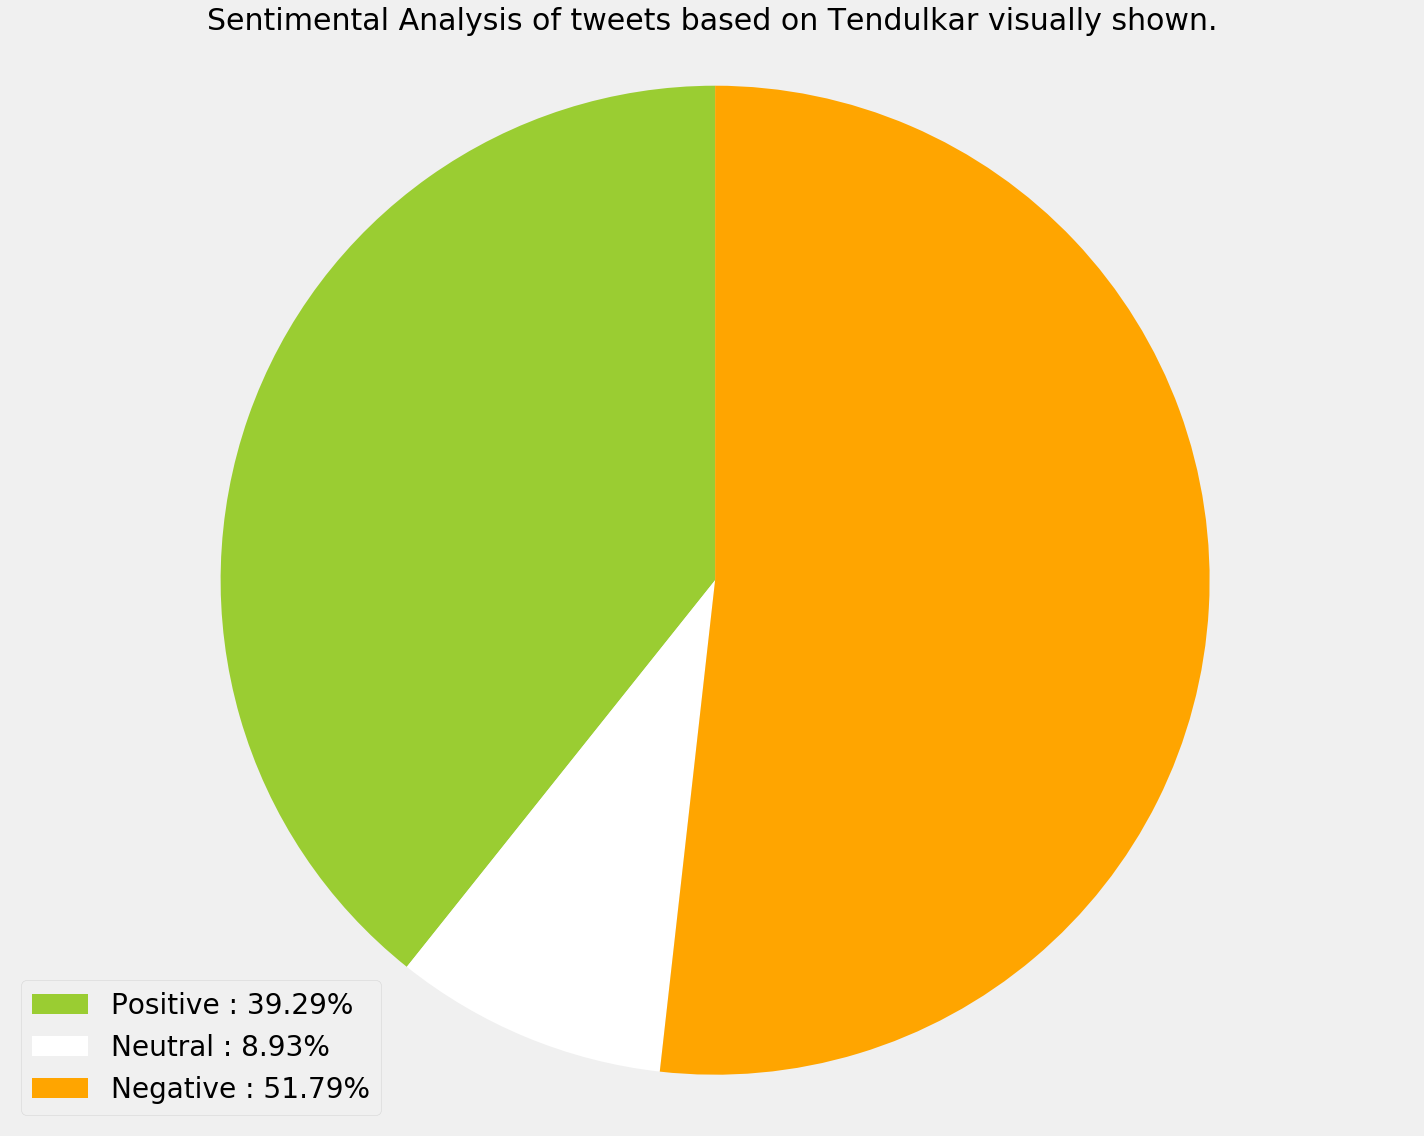

In [13]:
def percentage(part , whole):
    return 100 * float(part) / float(whole)

neutral = 0
positive = 0
negative = 0
count = 0
for polarity in open('./tmp/sentiments.txt' , 'r'):
    if(float(polarity.strip()) == 0):
        neutral += 1
    elif(float(polarity.strip()) < 0.00):
        negative += 1
    elif(float(polarity.strip()) > 0.00):
        positive += 1
        
    count += 1
# print(count)

positive = percentage(positive , count)
neutral = percentage(neutral , count)
negative = percentage(negative , count)

positive = format(positive , '.2f')
neutral = format(neutral , '.2f')
negative = format(negative , '.2f')


labels = ['Positive : ' + str(positive) + '%' , 'Neutral : ' + str(neutral) + '%' , 'Negative : ' + str(negative) + '%']
sizes = [positive , neutral , negative]
colors = ['yellowgreen' , 'white' , 'orange']

style.use("fivethirtyeight")
pyplot.figure(figsize = (20,16))
patches , text = pyplot.pie(sizes , colors = colors , startangle = 90)
pyplot.legend(patches , labels , loc = 'best' , prop = {'size' : 28})
pyplot.title("Sentimental Analysis of tweets based on " + ''.join(query) + " visually shown." , fontdict = {'fontsize' : 30})
pyplot.axis("equal")
pyplot.tight_layout()


In [17]:
pandas.set_option('display.max_colwidth' , -1)
def getSentiments():
    positive = []
    negative = []
    neutral = []
    for data in open('./tmp/data.json' , 'r' , newline = '\r\n'):
        megaData = json.loads(data)
        tweet = megaData['text']
        blob = TextBlob(tweet).sentiment
        if(blob.polarity > 0):
            positive.append(tweet)
        elif(blob.polarity < 0):
            negative.append(tweet)
        elif(blob.polarity == 0):
            neutral.append(tweet)
    return pandas.DataFrame({"Positive" : positive}) , pandas.DataFrame({"Neutral" : neutral}) , pandas.DataFrame({"Negative" : negative})

positivedf , neutraldf , negativedf = getSentiments()

In [18]:
negativedf.head()

,Negative
0,"RT @CNN: “We’ve seen horrible things over the years,” says actor Robert De Niro, but the Trump presidency is “one of the worst that I have…"
1,RT @EricBoehlert: Trump’s irrelevant https://t.co/BhYzinl8xu
2,Trump’s shitty policies putting (among others) his Republican base on welfare. It’s almost poetic
3,"RT @ShawnG927: This weekend, Alec Baldwin went on another anti-Trump name calling tirade! He even called Trump a “Rude, thoughtless, little…"
4,RT @charliekirk11: I am sick of my tax dollars being used to dig up dirt against Donald Trump while the evidence is blatantly clear against…
